In [5]:
df = pd.read_csv("/Users/nicole.li/Downloads/usage date mrr.csv")
df['usage_date'] = pd.to_datetime(df['usage_date'])

First lets take a look at the data and its time series decomposition to determine whats the best algorithm for long term forecast. Provided that this is weekly usaged based MRR, we won't see much seasonality, so likely we will focus on trend modeling.


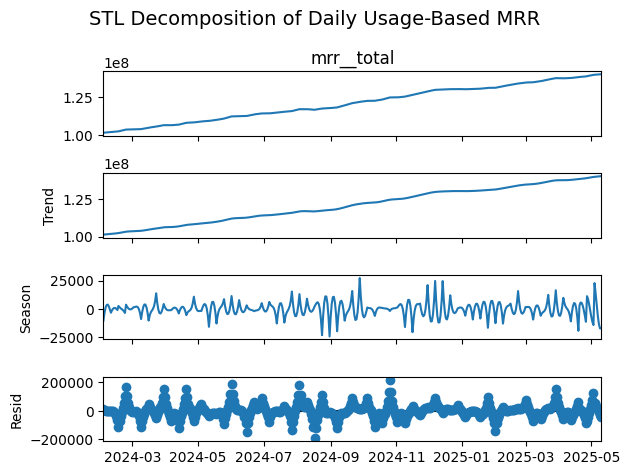

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Run STL decomposition with weekly seasonality (7-day)
stl = STL(df['mrr__total'], period=7)
result = stl.fit()

# Plot the components
fig = result.plot()
fig.suptitle("STL Decomposition of Daily Usage-Based MRR", fontsize=14)
plt.tight_layout()
plt.show()

Seasonality: Weekly (7day) seasonality is weak although consistent, I then also checked monthly and quarterly and found no clear patterns.
Trend: stronf linear upward trend signal, with no significant change points.
Residual: appears to be random across all decompositions

Conclusion: The hypothesis is correct, ad I will focus on modeling the trend with the consideration of weak weekly seasonality.
1. Prophet is not a good model here as it handles more trend shifts,
2. and likely SARIMA xcould work well.
3. weill also try ARIMA to see if the weak seasonality is important for forecast accuracy



SARIMA model testing on 76 days holdout -as we want to predict 7/31 and thats 76days from now

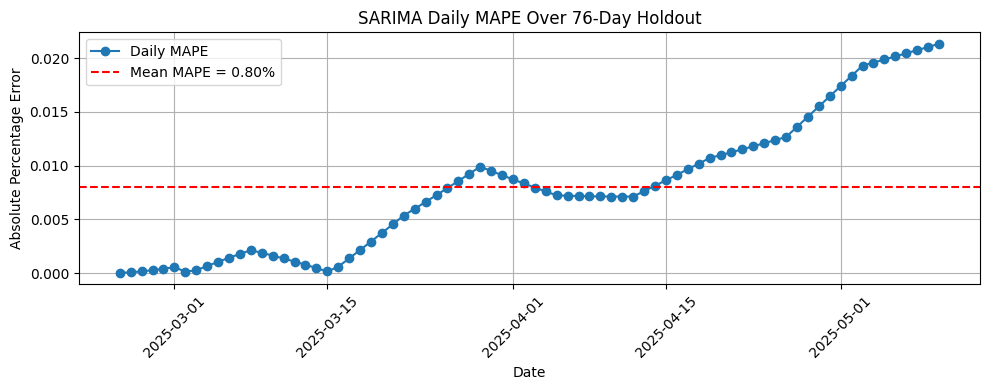

Mean MAPE: 0.80%
Exit MAPE: 2.13% | Exit MAE: $2,989,968


In [11]:
# Train/test split
train = df.iloc[:-76]
test = df.iloc[-76:]

# Fit SARIMA (weekly seasonality)
model = SARIMAX(train['mrr__total'],
                order=(1, 1, 1),
                seasonal_order=(1, 0, 1, 7),
                enforce_stationarity=False,
                enforce_invertibility=False)
result = model.fit()

# Forecast
forecast = result.forecast(steps=76)

# Compute daily MAPE
y_true = test['mrr__total'].values
y_pred = forecast.values
daily_mape = np.abs((y_true - y_pred) / y_true)

# Exit day
exit_mape = daily_mape[-1]
exit_mae = abs(y_true[-1] - y_pred[-1])

# Plot daily MAPE
plt.figure(figsize=(10, 4))
plt.plot(test.index, daily_mape, marker='o', label='Daily MAPE')
plt.axhline(daily_mape.mean(), color='red', linestyle='--', label=f'Mean MAPE = {daily_mape.mean():.2%}')
plt.title("SARIMA Daily MAPE Over 76-Day Holdout")
plt.xlabel("Date")
plt.ylabel("Absolute Percentage Error")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary
print(f"Mean MAPE: {daily_mape.mean():.2%}")
print(f"Exit MAPE: {exit_mape:.2%} | Exit MAE: ${exit_mae:,.0f}")

The exit MAPE is much lower than daily revenue forecast, and thr billing date MRR forecast that we have worked on. The mean MAPE is very low and gives me a lot of hope!

The MAPE shows a upward trend which is very interesting, I'm guessing that the SARIMA is not able to capture the growth trend very well, not exactly sure why but I will experiment with several other algorithms.

ARIMA with 76days hold out

/Users/nicole.li/.pyenv/versions/3.10.11/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


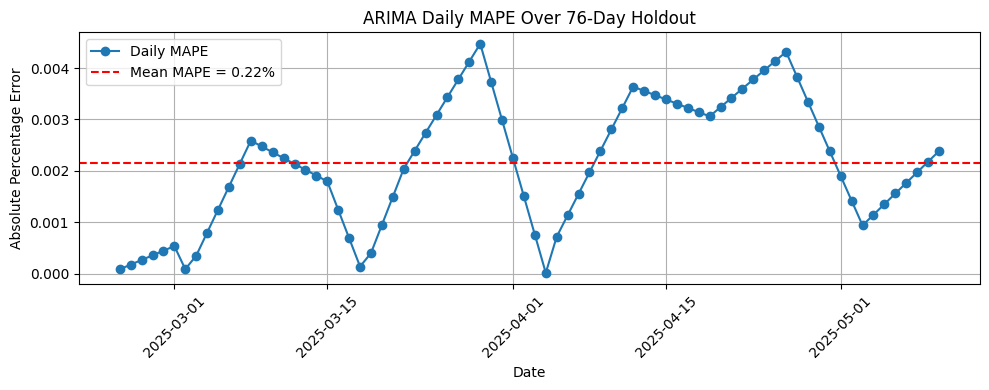

Mean MAPE: 0.22%
Exit MAPE: 0.24% | Exit MAE: $334,376


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

# Split data
train = df.iloc[:-76]
test = df.iloc[-76:]

# Fit ARIMA (no seasonality)
model = ARIMA(train['mrr__total'], order=(1, 1, 1))
result = model.fit()

# Forecast 76 days
forecast = result.forecast(steps=76)

# Compute daily MAPE
y_true = test['mrr__total'].values
y_pred = forecast.values
daily_mape = np.abs((y_true - y_pred) / y_true)

# Exit day metrics
exit_mape = daily_mape[-1]
exit_mae = abs(y_true[-1] - y_pred[-1])

# Plot daily MAPE
plt.figure(figsize=(10, 4))
plt.plot(test.index, daily_mape, marker='o', label='Daily MAPE')
plt.axhline(daily_mape.mean(), color='red', linestyle='--', label=f'Mean MAPE = {daily_mape.mean():.2%}')
plt.title("ARIMA Daily MAPE Over 76-Day Holdout")
plt.xlabel("Date")
plt.ylabel("Absolute Percentage Error")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print metrics
print(f"Mean MAPE: {daily_mape.mean():.2%}")
print(f"Exit MAPE: {exit_mape:.2%} | Exit MAE: ${exit_mae:,.0f}")

The MAPE is incredibly low and I'm in doubt of this model lol. so I will look at rolling window validation to confirm the model performnce

In [10]:

from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")  # suppress convergence warnings

# Rolling holdout config
horizon = 76
n_windows = 5
step = 7  # slide forward by 1 week

rolling_results = []
for i in range(n_windows):
    train_end = -horizon - step * (n_windows - 1 - i)
    if abs(train_end) + horizon > len(df):
        continue

    train = df.iloc[:train_end]
    test = df.iloc[train_end:train_end + horizon]

    if len(test) < horizon:
        continue

    try:
        model = ARIMA(train['mrr__total'], order=(1, 1, 1))
        result = model.fit()
        forecast = result.forecast(steps=horizon)

        y_true = test['mrr__total'].values
        y_pred = forecast.values
        daily_mape = np.abs((y_true - y_pred) / y_true)
        exit_mape = daily_mape[-1]
        exit_mae = abs(y_true[-1] - y_pred[-1])

        rolling_results.append({
            'window': i + 1,
            'mean_mape': daily_mape.mean(),
            'exit_mape': exit_mape,
            'exit_mae': exit_mae
        })
    except:
        continue

# Results as DataFrame
rolling_df = pd.DataFrame(rolling_results)
print(rolling_df)

   window  mean_mape  exit_mape      exit_mae
0       1   0.004664   0.002983  4.103652e+05
1       2   0.007935   0.007576  1.047372e+06
2       3   0.003884   0.001153  1.599090e+05
3       4   0.001905   0.000412  5.761779e+04


The MAPE is consistently low, the exit mape is great as well.now lets look at 90 days forecast instead

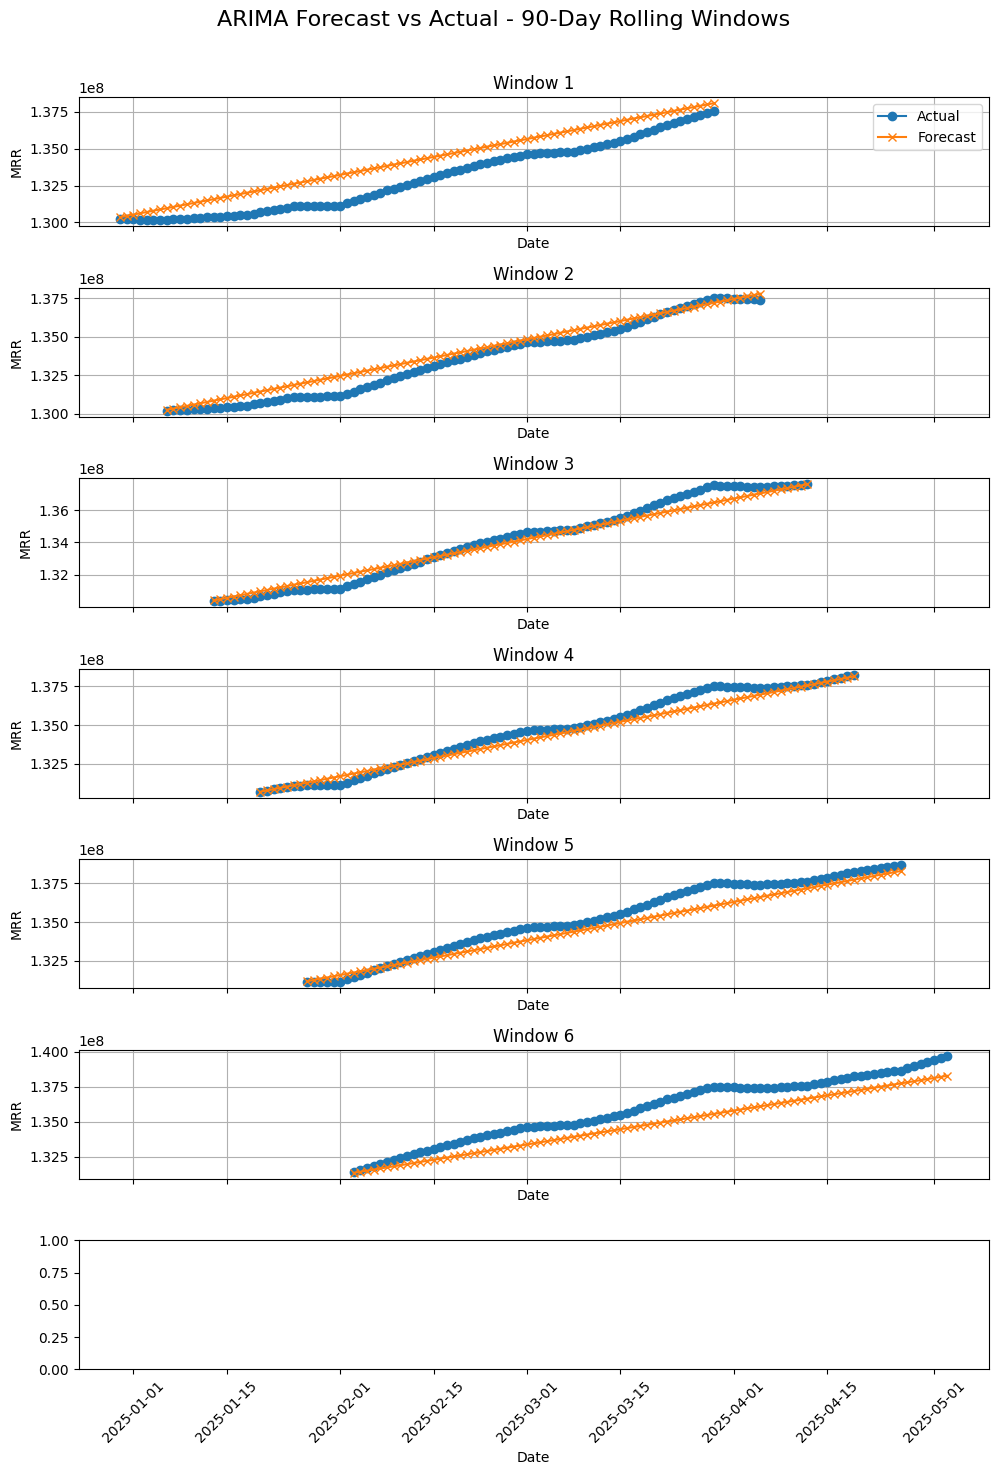

In [18]:
# Parameters
horizon = 90
n_windows = 7
step = 7
max_valid_windows = 4

# Set up plot grid
fig, axs = plt.subplots(n_windows, 1, figsize=(10, 15), sharex=True)
fig.suptitle("ARIMA Forecast vs Actual - 90-Day Rolling Windows", fontsize=16)

for i in range(n_windows):
    train_end = -horizon - step * (n_windows - 1 - i)
    if abs(train_end) + horizon > len(df):
        continue

    train = df.iloc[:train_end]
    test = df.iloc[train_end:train_end + horizon]

    if len(test) < horizon:
        continue

    try:
        model = ARIMA(train['mrr__total'], order=(1, 1, 1))
        result = model.fit()
        forecast = result.forecast(steps=horizon)

        axs[i].plot(test.index, test['mrr__total'], label="Actual", marker='o')
        axs[i].plot(test.index, forecast, label="Forecast", marker='x')
        axs[i].set_title(f"Window {i+1}")
        axs[i].set_xlabel("Date")
        axs[i].set_ylabel("MRR")
        axs[i].tick_params(axis='x', rotation=45)
        axs[i].grid(True)
    except:
        axs[i].set_title(f"Window {i+1} - Error")
        axs[i].axis('off')
        continue

plt.xlabel("Date")
plt.xticks(rotation=45)
axs[0].legend()
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Now I will validate based on quarters rather than rolloing validation

Q1 FY26 Forecast — Mean MAPE: 0.31%, Exit MAPE: 0.20%, Exit MAE: $276,060


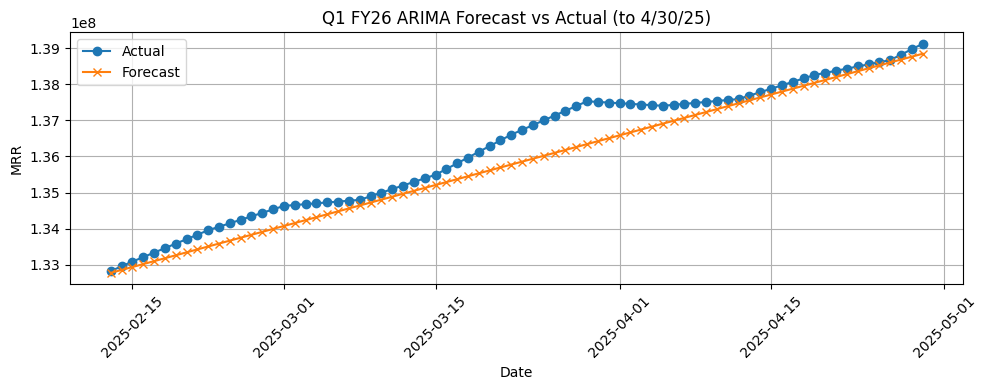

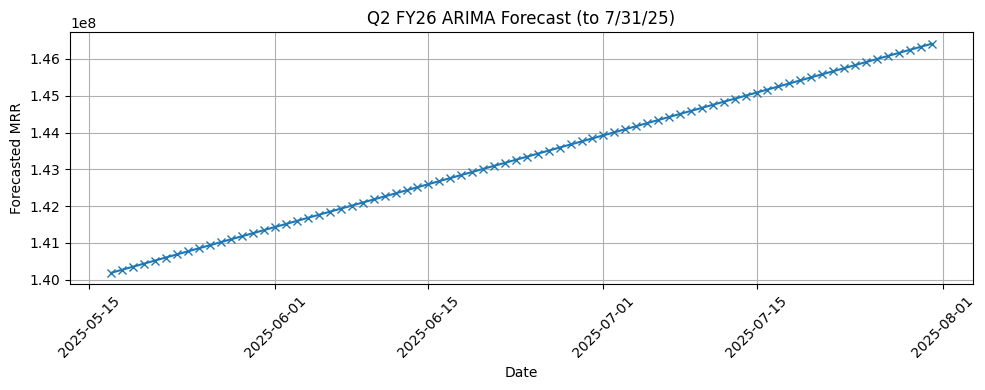

In [19]:
# Dates
q1_fy26_end = pd.Timestamp("2025-04-30")
q2_fy26_end = pd.Timestamp("2025-07-31")
horizon = 76

# -------- Q1 FY26 Validation (forecast to 4/30/2025) --------
start_q1 = q1_fy26_end - pd.Timedelta(days=horizon)
train_q1 = df[df.index < start_q1]
test_q1 = df[(df.index >= start_q1) & (df.index <= q1_fy26_end)].iloc[:horizon]

# Fit + Forecast
model_q1 = ARIMA(train_q1['mrr__total'], order=(1, 1, 1))
result_q1 = model_q1.fit()
forecast_q1 = result_q1.forecast(steps=horizon)

# Evaluate
y_true_q1 = test_q1['mrr__total'].values
y_pred_q1 = forecast_q1.values
daily_mape_q1 = np.abs((y_true_q1 - y_pred_q1) / y_true_q1)
mean_mape_q1 = daily_mape_q1.mean()
exit_mape_q1 = daily_mape_q1[-1]
exit_mae_q1 = abs(y_true_q1[-1] - y_pred_q1[-1])

print(f"Q1 FY26 Forecast — Mean MAPE: {mean_mape_q1:.2%}, Exit MAPE: {exit_mape_q1:.2%}, Exit MAE: ${exit_mae_q1:,.0f}")

# Plot Q1 validation
plt.figure(figsize=(10, 4))
plt.plot(test_q1.index, y_true_q1, label="Actual", marker='o')
plt.plot(test_q1.index, y_pred_q1, label="Forecast", marker='x')
plt.title("Q1 FY26 ARIMA Forecast vs Actual (to 4/30/25)")
plt.xlabel("Date")
plt.ylabel("MRR")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------- Q2 FY26 Forecast (to 7/31) --------
start_q2 = q2_fy26_end - pd.Timedelta(days=horizon)
train_q2 = df[df.index < start_q2]

# Fit + Forecast
model_q2 = ARIMA(train_q2['mrr__total'], order=(1, 1, 1))
result_q2 = model_q2.fit()
forecast_q2 = result_q2.forecast(steps=horizon)

# Plot Q2 forecast
forecast_dates_q2 = pd.date_range(start=q2_fy26_end - pd.Timedelta(days=horizon - 1), periods=horizon)
plt.figure(figsize=(10, 4))
plt.plot(forecast_dates_q2, forecast_q2.values, label="Forecast", marker='x')
plt.title("Q2 FY26 ARIMA Forecast (to 7/31/25)")
plt.xlabel("Date")
plt.ylabel("Forecasted MRR")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
forecast_dates_q2 = pd.date_range(start=q2_fy26_end - pd.Timedelta(days=horizon - 1), periods=horizon)
exit_mrr_q2 = forecast_q2.values[-1]
print(f"Q2 FY26 Forecasted Exit MRR (7/31/25): ${exit_mrr_q2:,.0f}")


Q2 FY26 Forecasted Exit MRR (7/31/25): $146,412,071


7/31 MRR weekly MRR is $146,412,071 and now lets convert it to w/w growth rate

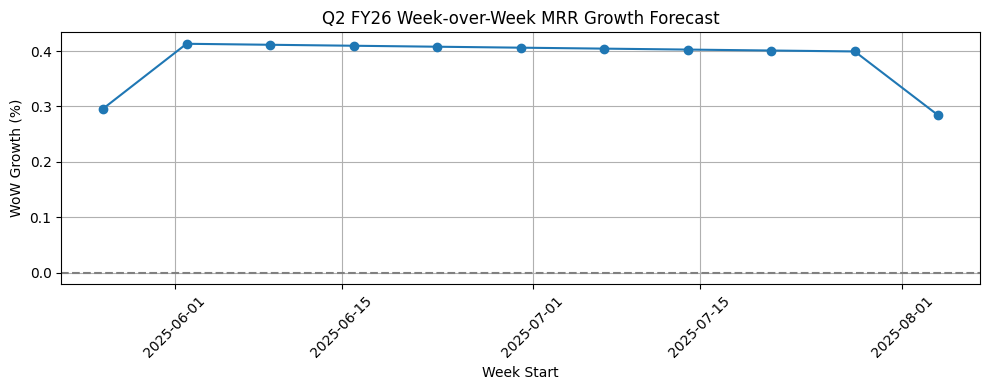

In [21]:
# Forecast dates and values from earlier forecast
forecast_q2_df = pd.DataFrame({
    'date': forecast_dates_q2,
    'mrr_forecast': forecast_q2.values
})

# Filter to Q2 FY26 (May 1 – July 31)
q2_window = forecast_q2_df[
    (forecast_q2_df['date'] >= '2025-05-01') &
    (forecast_q2_df['date'] <= '2025-07-31')
].set_index('date')

# Resample to weekly averages (Sun to Sat by default, shift to Mon-Sun)
weekly_mrr = q2_window['mrr_forecast'].resample('W-MON').mean()

# Compute WoW % change
wow_growth = weekly_mrr.pct_change().dropna() * 100

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(wow_growth.index, wow_growth, marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Q2 FY26 Week-over-Week MRR Growth Forecast")
plt.xlabel("Week Start")
plt.ylabel("WoW Growth (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
print(wow_growth)

date
2025-05-26    0.295989
2025-06-02    0.413098
2025-06-09    0.411319
2025-06-16    0.409555
2025-06-23    0.407806
2025-06-30    0.406071
2025-07-07    0.404351
2025-07-14    0.402645
2025-07-21    0.400953
2025-07-28    0.399275
2025-08-04    0.284018
Freq: W-MON, Name: mrr_forecast, dtype: float64
